In [2]:
#Importamos librerias
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np
from sklearn.metrics import r2_score

In [3]:
#Ponemos algunas opciones del jupyter-notebook 
pd.set_option('display.max_columns', None)
pd.options.display.max_rows = 999

In [4]:
#Leemos los datos
data_hr=pd.read_excel("DemandaEnergia.xlsx", sheet_name='Hourly Data')
data_d=pd.read_excel("DemandaEnergia.xlsx", sheet_name='Daily Data')

In [5]:
#Creamos el dataframe usando nuestras fechas

data_hr=pd.DataFrame({'demand':data_hr['D'],'date_time':pd.to_datetime(pd.date_range(start='2015/07/01', end='2021/11/30 15:00', freq='H'))}).set_index('date_time')




In [6]:
#CAgrupamos para formato diario de los datos. 
data_hr_d=data_hr.resample('D').sum()

In [7]:
data_d=data_d.rename(columns={'Local date':'date_time'}).set_index('date_time')[['D']]

In [8]:
#Chequeamos
data_d.head()

,D
date_time,
2015-07-01,978699
2015-07-02,962751
2015-07-03,887079
2015-07-04,830874
2015-07-05,791310


In [9]:
#Unimos los dos datasets y hacemos las diferencias a verlas

df_join=data_d.join(data_hr_d, how='inner')

In [10]:
df_join['dif']=df_join['D']-df_join['demand']

In [11]:
df_join[df_join['dif']!=0].head()

,D,demand,dif
date_time,,,
2015-11-01,697604,670384,27220
2015-11-02,728428,727825,603
2015-11-03,705853,705822,31
2015-11-04,709170,708652,518
2015-11-05,720249,719897,352


Las diferencias significativas parecen ser de contabilizar en un día consumo de otro, por ejemplo de la última hora en la hora del día siguiente uy en el último día que es porque tenemos solo los datos hasta las 3 de la tarde. 

Trabajaremos con los datos horarios durante todo el ejercicio. Sin embargo, cuando hagamos las predicciones diarias, cambiareemos el dataset para que este último día incluya la demanda entera. 

<AxesSubplot:xlabel='date_time'>

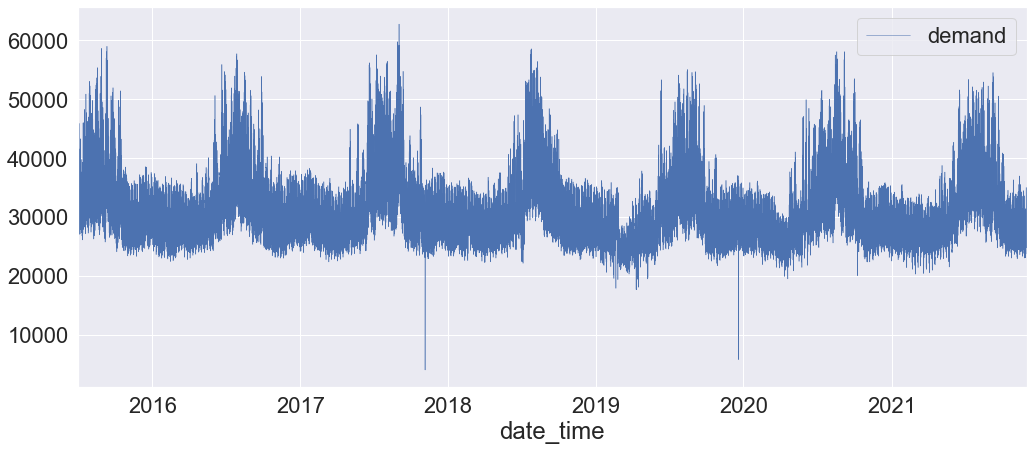

In [12]:
sns.set(rc={'figure.figsize':(17, 7)})
sns.set(font_scale = 2)
data_hr.plot(linewidth=0.5)


Vamos a verficar si los datos horarios corresponden con los diaros

Parece que tenemos algunos outliears viendolo en en formato horario. Pues hay algunos datos que están por debajo de 10.000 en demanda, veamos cuales son

In [13]:
data_hr[data_hr.demand < 10000]

,demand
date_time,
2017-11-05 00:00:00,3964
2019-12-19 16:00:00,5719
2019-12-19 17:00:00,6103
2019-12-19 18:00:00,6597


Veremos como se comporta la demanda a niveel horario. 

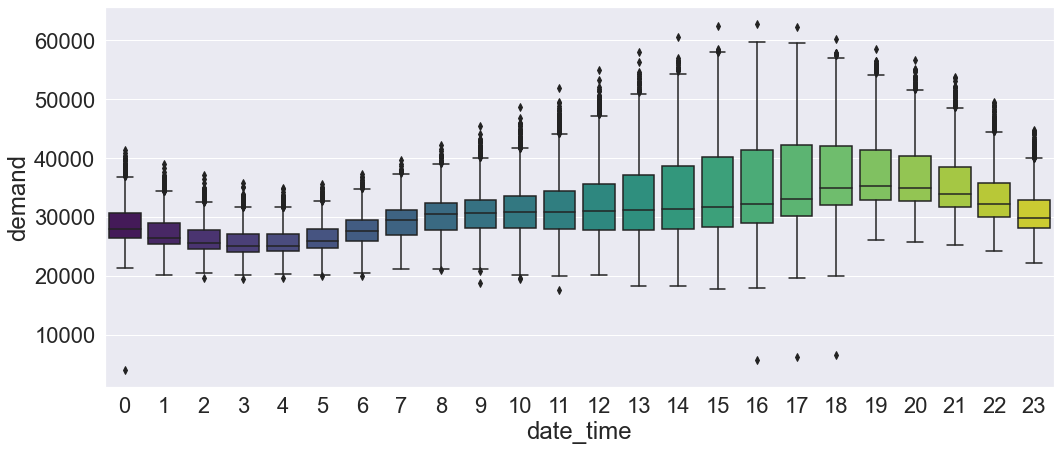

In [14]:
times=pd.DatetimeIndex(data_hr.index)
#Creamos un boxplot para ver las demandas por hora
ax = sns.boxplot(x=times.hour, y="demand", data=data_hr,palette= 'viridis')


In [15]:
data_hr['H']=data_hr.index.hour

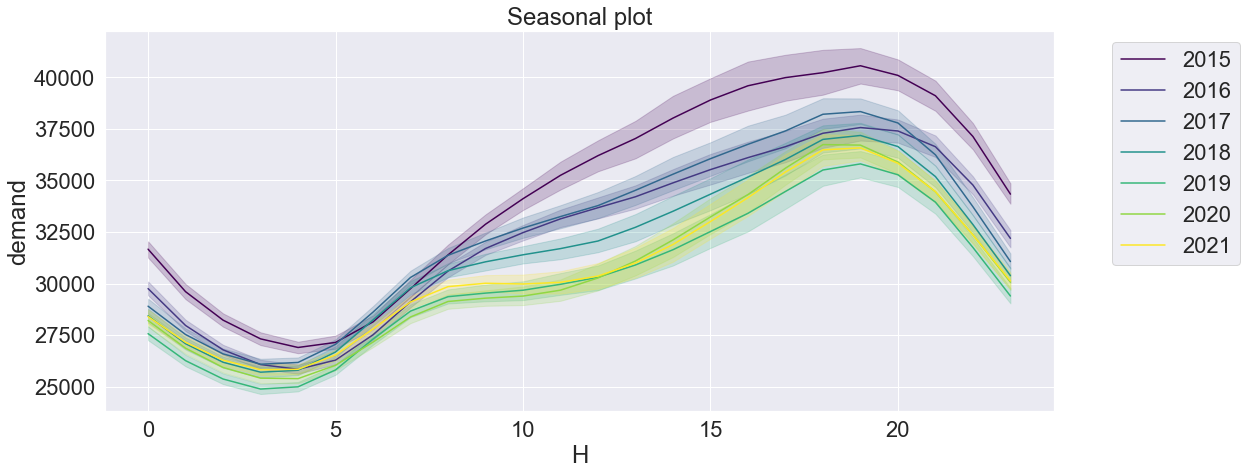

In [16]:
data_hr['Y'] = data_hr.index.year
sns.lineplot(data=data_hr, 
             x='H', 
             y='demand', 
             hue='Y', 
             legend='full',palette= 'viridis' )

# add title
plt.title('Seasonal plot')

# move the legend outside of the main figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2);

### Características a nivel diario


Meadiante este grafico analizamos la estacionalidad de la data, viendo que efectivamente hay un componente etacional fuerte en los meses de verano, en el que la demanda de electricidad aumenta. 

<AxesSubplot:xlabel='date_time'>

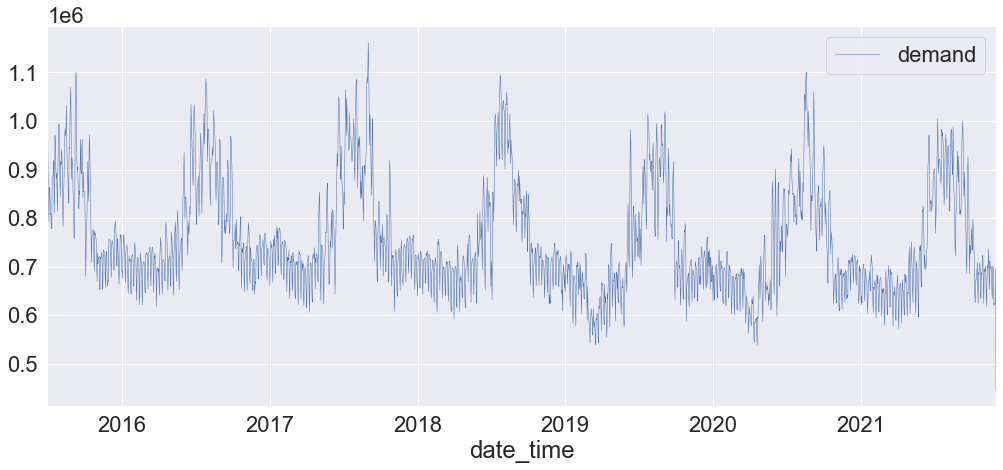

In [17]:
data_hr_d.plot(linewidth=0.5)

In [18]:
times=data_hr_d.index

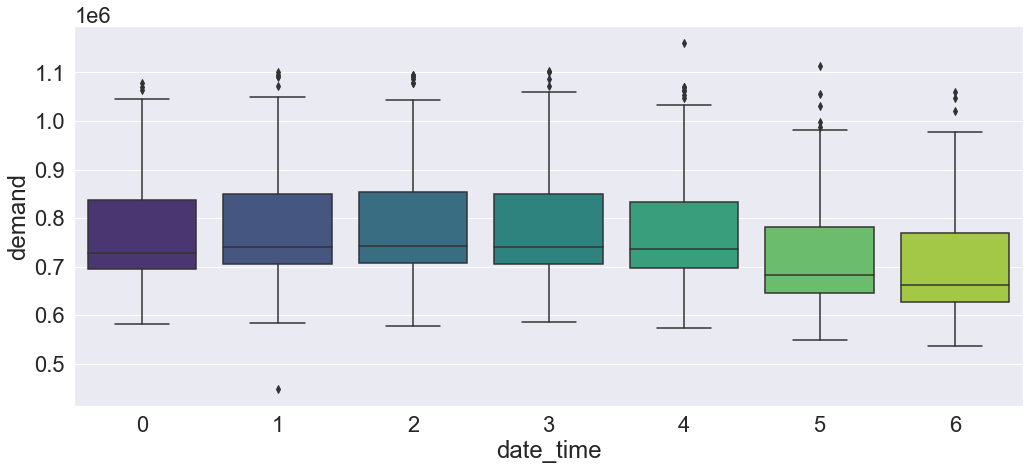

In [19]:
ax = sns.boxplot(x=times.weekday, y="demand", data=data_hr_d,palette= 'viridis')

Será que hay distintos tipos de demanda dependiente del mes en el que estemos?

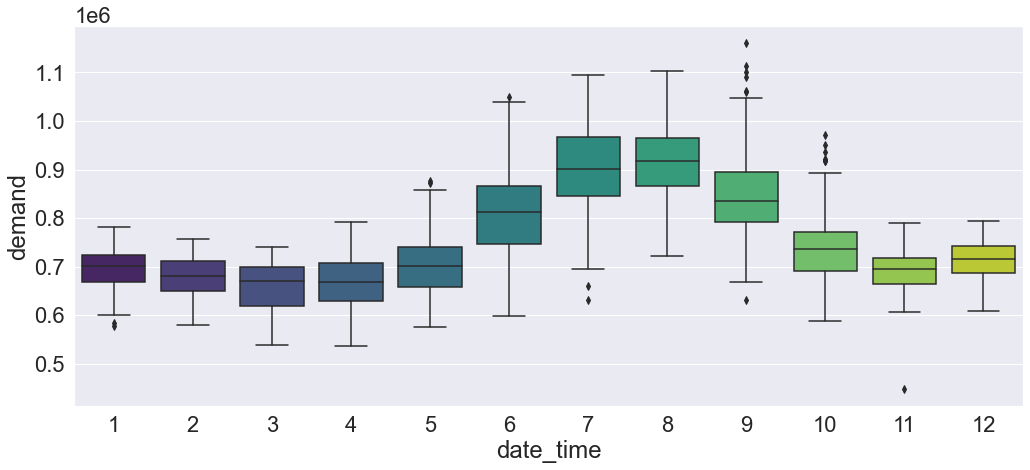

In [20]:
ax = sns.boxplot(x=times.month, y="demand", data=data_hr_d,palette= 'viridis')

In [21]:
data_d.head()

,D
date_time,
2015-07-01,978699
2015-07-02,962751
2015-07-03,887079
2015-07-04,830874
2015-07-05,791310


Confirmamos que en los meses de verano hay más demanda que en los meses de invierno, esto puede deberse a que durante los meses de verano se usan los aures acondicionados mientras que en invierno California no es excesivamente fría, y hay alternativas como el gas para las calefacciones

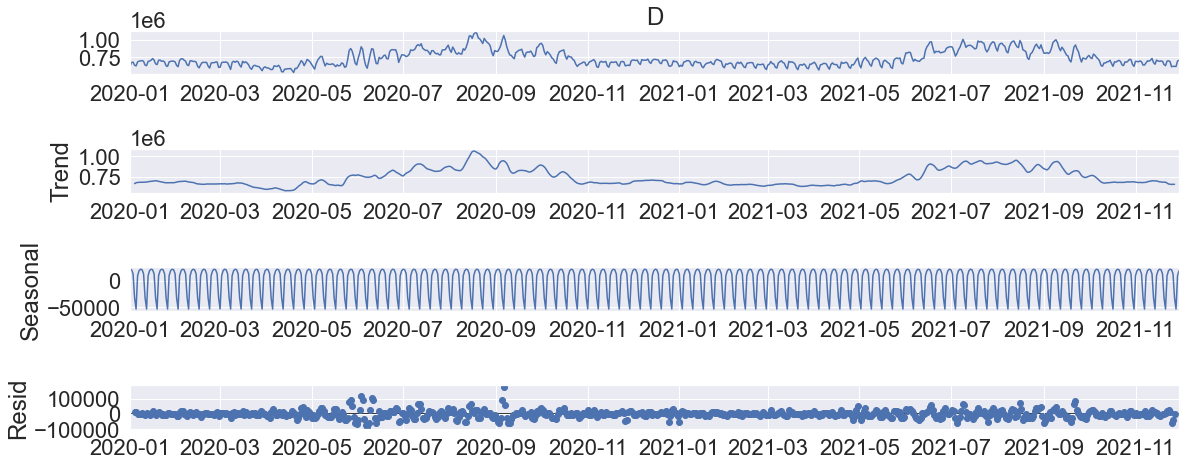

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data_d['D']['2020':])
decomposition.plot();

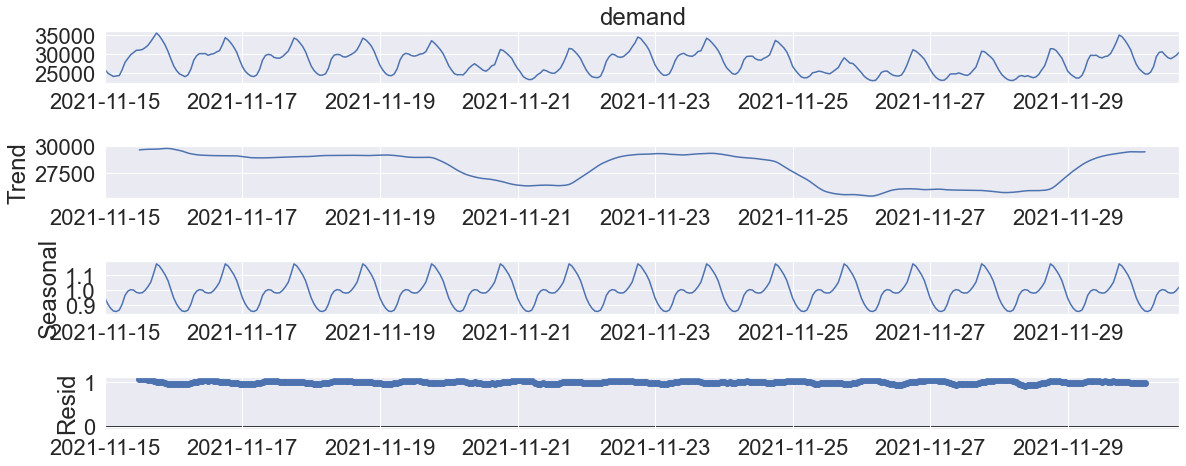

In [23]:
sns.set(font_scale = 2)
decomposition = seasonal_decompose(data_hr['demand']['2021-11-15':], 
                                   model='multiplicative')
decomposition.plot();

Mediante este gráfico podemos hacer las siguientes observaciones:

Los datos no siguen una tendencia específica, pues no presentan una dirección a largo plazo, pero si podemos ver que presentan una periodisidad que se repite semanalmente. Pues es la seasonality podemos ver que es un patrón que se repite. 



## Modelo de Suavizado Exponencial
Utilizarmeos el método de suavizado exponencial para hacer las predicciones. Este método asigna pesos en base a las medias ponderadas de observaciones anteriores. Dando un mayor peso a las obsevaciones más recientes. 

Gracias a la utilización de este modelo podemos tomar en cuenta el trend, el seasonality y el ruido, de la serie.

In [24]:
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.ets import AutoETS

In [25]:
from sktime.forecasting.ets import AutoETS

### ETS A NIVEL DIARIO

In [26]:
data_hr_d=data_hr_d[:-1]


In [27]:
y_train_d, y_test_d = temporal_train_test_split(y = data_hr_d['demand'].astype('float64').to_period('D')['2019-10-01':], test_size=30)


761 30


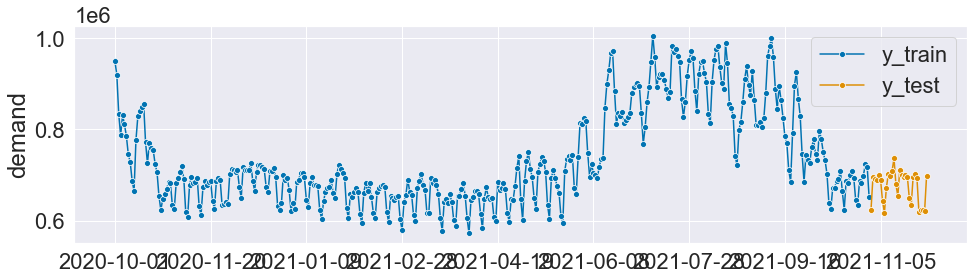

In [28]:
plot_series(y_train_d['2020-10-01':], y_test_d, labels=["y_train", "y_test"])
print(y_train_d.shape[0], y_test_d.shape[0])

In [29]:
ets_model = AutoETS(auto=True, n_jobs=-1,sp=7)

In [30]:
fh = np.arange(1, 31)

In [31]:
ets_model.fit(y_train_d)

AutoETS(auto=True, n_jobs=-1, sp=7)

In [32]:
print(ets_model.summary())

                                 ETS Results                                  
Dep. Variable:                 demand   No. Observations:                  761
Model:                       ETS(MNM)   Log Likelihood               -8795.584
Date:                Fri, 21 Jan 2022   AIC                          17613.169
Time:                        15:55:49   BIC                          17664.150
Sample:                    10-01-2019   HQIC                         17632.799
                         - 10-30-2021   Scale                            0.001
Covariance Type:               approx                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
smoothing_level        0.9999      0.046     21.736      0.000       0.910       1.090
smoothing_seasonal  4.589e-05      0.017      0.003      0.998      -0.033       0.033
initial_level       

Según nuestro modelo, dice que que tenemos un unos errores multiplicativos, no tiene un trend, lo cual lo confirma nuestros gráficos y tiene un seasonality que se comporta de manera multiplicativa.

Lo que hace el modelo de suavizado exponencial es considerar que tiene que agregar un componente de forma multiplicativa para la seasonality y otro para errores, sin embargo, no va a agregar ningún tipo de componente para el trend.


In [33]:
y_pred_d=ets_model.predict(fh)
y_pred_d.head()

2021-10-31    631125.390141
2021-11-01    691096.047548
2021-11-02    701025.254187
2021-11-03    702498.070339
2021-11-04    701375.032782
Freq: D, dtype: float64

In [34]:
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import MeanSquaredError

In [35]:
mse = MeanSquaredError()
rmse = MeanSquaredError(square_root=True)

In [36]:
print('La media del error absoluto porcental es:',round(mean_absolute_percentage_error(y_test_d, y_pred_d),3))
print('El error cuadratico medio es:',round(mse(y_test_d, y_pred_d),3))
print('El error medio en terminos absolutos:',round(rmse(y_test_d, y_pred_d),3))

La media del error absoluto porcental es: 0.022
El error cuadratico medio es: 573666379.444
El error medio en terminos absolutos: 23951.334


761 30


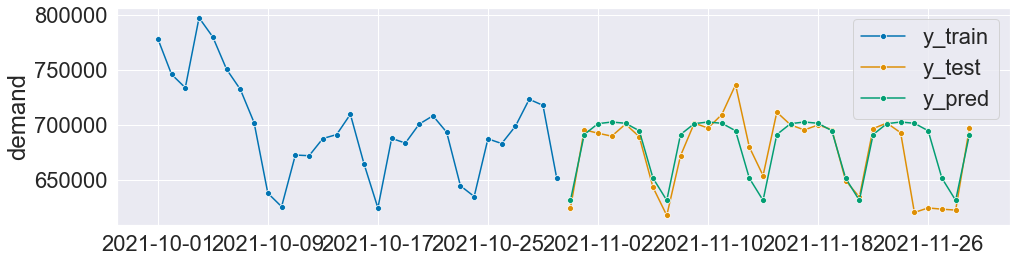

In [37]:
plot_series(y_train_d['2021-10-01':], y_test_d, y_pred_d,labels=["y_train", "y_test","y_pred"])
print(y_train_d.shape[0], y_test_d.shape[0])

Para forecastear los siguientes 15 días de diciembre haremos un predict de 15 días:


In [38]:
#Vamos a foreastear los siguientes días. 
y_d = data_hr_d['demand'].astype('float64').to_period('D')['2019-10-01':]
ets_model.fit(y_d)
fh_d = np.arange(1, 17)
forecast_d_ets=ets_model.predict(fh_d)
forecast_d_ets

2021-11-30    706943.026569
2021-12-01    708158.537776
2021-12-02    706693.418998
2021-12-03    700175.013234
2021-12-04    656858.613563
2021-12-05    636484.685505
2021-12-06    697120.153039
2021-12-07    706943.026569
2021-12-08    708158.537776
2021-12-09    706693.418998
2021-12-10    700175.013234
2021-12-11    656858.613563
2021-12-12    636484.685505
2021-12-13    697120.153039
2021-12-14    706943.026569
2021-12-15    708158.537776
Freq: D, dtype: float64

Confirmamos que el modelo sigue siendo el mismo al reentranar ahora incluyendo los datos de test, sin embargo el AIC aumenta, lo cual lo aleja de ser un mejor modelo que el primero que hemos entrenado. 

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='demand'>)

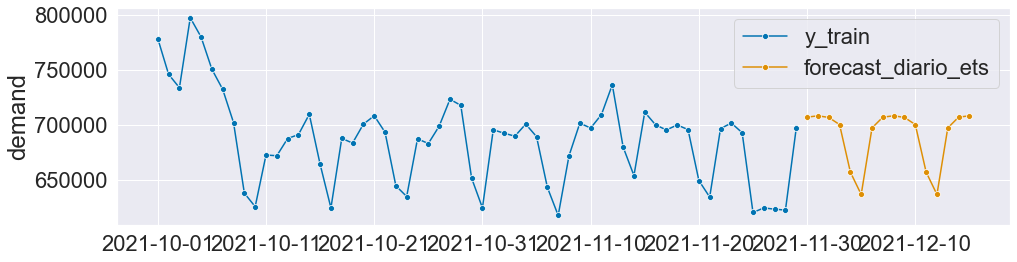

In [39]:
plot_series(y_d['2021-10-01':], forecast_d_ets,labels=["y_train", "forecast_diario_ets"])

## Forecas a nivel horario

In [40]:
y_train_h, y_test_h = temporal_train_test_split(y = data_hr['demand'].astype('float64').to_period('H')['2021-10-01':], test_size=48)

1408 48


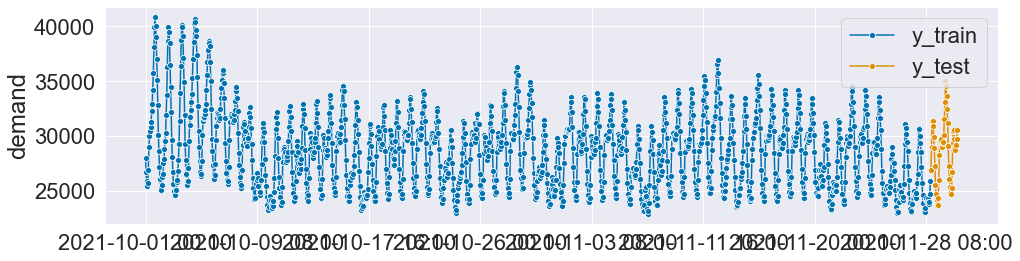

In [41]:
plot_series(y_train_h['2021-10-01':], y_test_h, labels=["y_train", "y_test"])
print(y_train_h.shape[0], y_test_h.shape[0])

In [42]:
ets_model_h = AutoETS(auto=True, n_jobs=-1,sp=24)

fh_h = np.arange(1, 49)

ets_model_h.fit(y_train_h)

y_pred_h=ets_model_h.predict(fh_h)
y_pred_h.head()

2021-11-28 16:00    27045.145627
2021-11-28 17:00    28543.097268
2021-11-28 18:00    29873.147955
2021-11-28 19:00    29795.621101
2021-11-28 20:00    29020.682204
Freq: H, dtype: float64

In [43]:
print(ets_model_h.summary())

                                 ETS Results                                  
Dep. Variable:                 demand   No. Observations:                 1408
Model:                      ETS(MAdM)   Log Likelihood              -10428.513
Date:                Fri, 21 Jan 2022   AIC                          20919.025
Time:                        15:55:54   BIC                          21081.773
Sample:                    10-01-2021   HQIC                         20979.847
                         - 11-28-2021   Scale                            0.000
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.9999      0.045     22.154      0.000       0.911       1.088
smoothing_trend         0.6578      0.091      7.192      0.000       0.479       0.837
smoothing_season

In [44]:
print('La media del error absoluto porcental es:',round(mean_absolute_percentage_error(y_test_h, y_pred_h),3))
print('El error cuadratico medio es:',round(mse(y_test_h, y_pred_h),3))
print('El error medio en terminos absolutos:',round(rmse(y_test_h, y_pred_h),3))

La media del error absoluto porcental es: 0.098
El error cuadratico medio es: 8319474.684
El error medio en terminos absolutos: 2884.35


1408 48


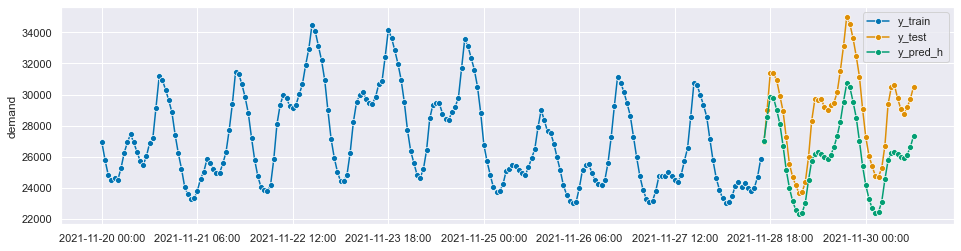

In [45]:
sns.set(font_scale = 1)
plot_series(y_train_h['2021-11-20':], y_test_h, y_pred_h,labels=["y_train", "y_test","y_pred_h"])
print(y_train_h.shape[0], y_test_h.shape[0])

In [46]:
#Vamos a foreastear los siguientes días. 
y_h = data_hr['demand'].astype('float64').to_period('H')['2021-10-01':]
ets_model_h.fit(y_h)
fh_h = np.arange(1, 178)
forecast_h_ets=ets_model_h.predict(fh_h)


El criterio de información de Akaike´s penaliza el fit del modelo utilizando el numero de parametros qu enecesita estimar. Mientras más pequeño sea el AIC, mejor será nuestro modelo. 

También podríamos utilzar el BIC para intentar buscar el mejor modelo, en este caso el BIC busca penalizar el numero de parámetros que el modelo tiene que estimar, la diferencia con el AIC es que el BIC toma más importancia esta penalización. 

1408 48


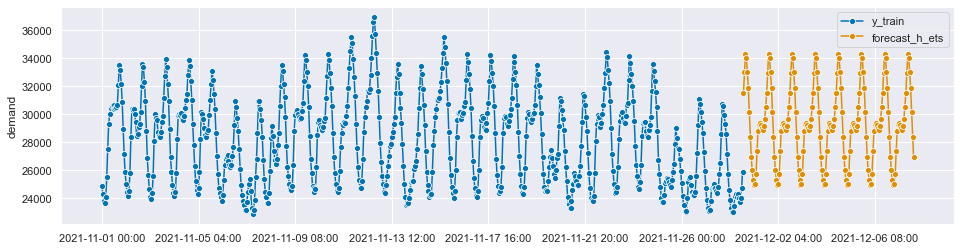

In [47]:
plot_series(y_train_h['2021-11-01':], forecast_h_ets,labels=["y_train", "forecast_h_ets"])
print(y_train_h.shape[0], y_test_h.shape[0])

Pasamos los 7 días horarios a diarios para comparar con los datos que hemos sacado con el otro forecast

In [48]:
#Hacemos el resample de los datos horarios a diarios para compararlos. Y creamos un data frame

pd.DataFrame({'forecast_horario':round(forecast_h_ets.resample('D').sum()[1:-1],2),'forecast_diario':round(forecast_d_ets[1:-8],2)})


,forecast_horario,forecast_diario
2021-12-01,701707.50,708158.54
2021-12-02,701699.02,706693.42
2021-12-03,701698.98,700175.01
2021-12-04,701698.98,656858.61
2021-12-05,701698.98,636484.69
2021-12-06,701698.98,697120.15
2021-12-07,701698.98,706943.03


## Modelo ARIMA

Utilizaremos el modelo ARIMA, ya que si bien el modelo de suavizado exponencial son buenos para determinar y describir las tendencia y la estacionalidad, el modelo ARIMA utilizará la autocorrelación de la data pasada para poder ajustar y predecir el futuro. 

Al ser la serie casi estacional pero con un gran componente de estacionalidad, utilizaremos el autoarima como el modelo para predecir, probablemente al vayamos a terminar usando un modelo SARIMAX, que incluye un componente estacional. (Seasonal ARIMA). La parte de la X, es la parte de variable exógena que se incluirá en el modelo. 




In [49]:
import statsmodels.api as sm
from sktime.forecasting.arima import AutoARIMA
from sktime.utils.plotting import plot_correlations
from sktime.transformations.series.boxcox import LogTransformer
from sktime.transformations.series.difference import Differencer

### ARIMA A NIVEL DIARIO

In [50]:
transformer = LogTransformer()

In [51]:
y_train_log= transformer.fit_transform(y_train_d)

(<Figure size 864x576 with 3 Axes>,
 array([<AxesSubplot:ylabel='demand'>,
        <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

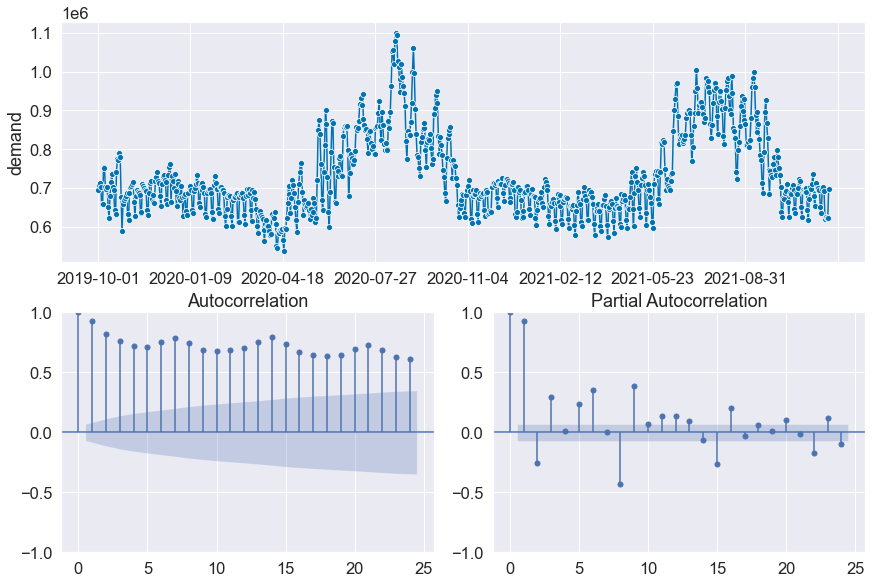

In [52]:
sns.set(font_scale = 1.5)
plot_correlations(data_hr_d['demand'].astype('float64').to_period('D')['2019-10-01':])

(<Figure size 864x576 with 3 Axes>,
 array([<AxesSubplot:ylabel='demand'>,
        <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

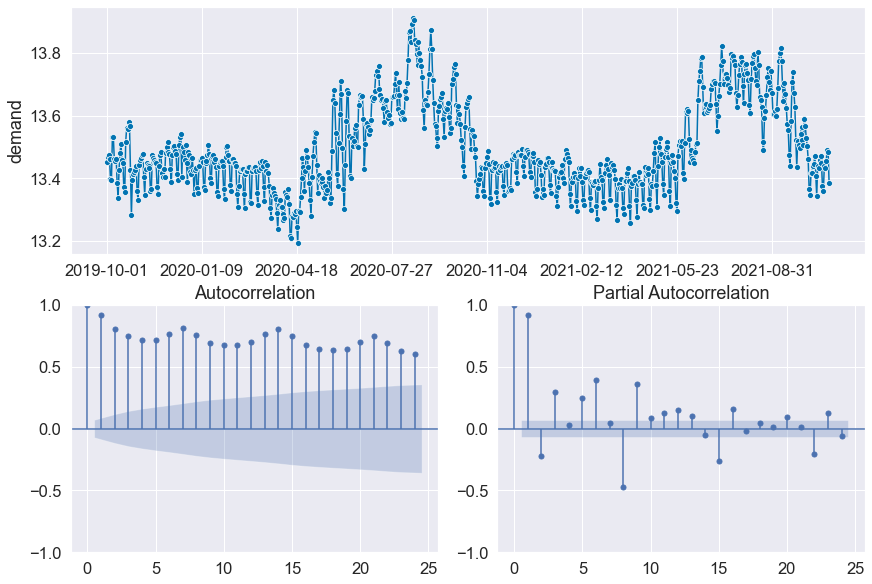

In [53]:
sns.set(font_scale = 1.5)
plot_correlations(y_train_log)

In [54]:
arima_d = AutoARIMA(sp=7,suppress_warnings=True)
arima_d.fit(y_train_log)

AutoARIMA(sp=7, suppress_warnings=True)

In [55]:
fh = np.arange(1, 31)

In [56]:
print(arima_d.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  761
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 7)   Log Likelihood                1533.348
Date:                           Fri, 21 Jan 2022   AIC                          -3054.695
Time:                                   15:57:20   BIC                          -3026.895
Sample:                                        0   HQIC                         -3043.990
                                           - 761                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1720      0.030     38.559      0.000       1.112       1.232
ar.L2         -0.4507      0.027    -16.688

In [57]:
y_pred_d=np.exp(arima_d.predict(fh))
y_pred_d.head()

2021-10-31    620178.350992
2021-11-01    669389.920321
2021-11-02    677212.561623
2021-11-03    681802.510860
2021-11-04    685772.687581
Freq: D, dtype: float64

In [58]:
print('La media del error absoluto porcental es:',round(mean_absolute_percentage_error(y_test_d, y_pred_d),3))
print('El error cuadratico medio es:',round(mse(y_test_d, y_pred_d),3))
print('El error medio en terminos absolutos:',round(rmse(y_test_d, y_pred_d),3))

La media del error absoluto porcental es: 0.041
El error cuadratico medio es: 1028735402.795
El error medio en terminos absolutos: 32073.905


761 30


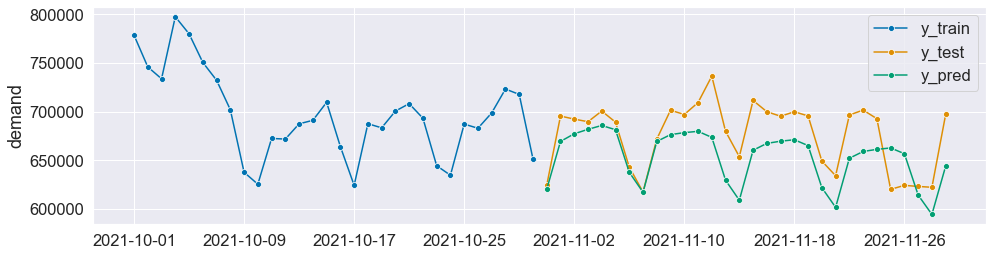

In [59]:
plot_series(y_train_d['2021-10-01':], y_test_d, y_pred_d,labels=["y_train", "y_test","y_pred"])
print(y_train_d.shape[0], y_test_d.shape[0])

Para forecastear los siguientes 15 días de diciembre haremos un predict de 15 días:


In [60]:
#Vamos a foreastear los siguientes días. 
y = transformer.fit_transform(data_hr_d['demand'].astype('float64').to_period('D')['2019-10-01':])
arima_d.fit(y)
fh = np.arange(1, 17)
forecast_d_arima=arima_d.predict(fh)
print(arima_d.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  791
Model:             SARIMAX(3, 1, 2)x(2, 0, 2, 7)   Log Likelihood                1595.653
Date:                           Fri, 21 Jan 2022   AIC                          -3171.307
Time:                                   15:59:00   BIC                          -3124.586
Sample:                                        0   HQIC                         -3153.348
                                           - 791                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3293      0.257      1.282      0.200      -0.174       0.832
ar.L2          0.4321      0.281      1.537

In [61]:
forecast_d_arima=np.exp(arima_d.predict(fh))

Confirmamos que el modelo sigue siendo el mismo al reentranar ahora incluyendo los datos de test, sin embargo el AIC aumenta, lo cual lo aleja de ser un mejor modelo que el primero que hemos entrenado. 

In [62]:
forecast_d_arima

2021-11-30    706202.184033
2021-12-01    701245.240396
2021-12-02    692760.252471
2021-12-03    680580.001012
2021-12-04    634937.581149
2021-12-05    614952.773630
2021-12-06    667745.324232
2021-12-07    674715.236105
2021-12-08    674331.478879
2021-12-09    669079.578857
2021-12-10    668241.867642
2021-12-11    630030.544465
2021-12-12    612116.028183
2021-12-13    667404.102718
2021-12-14    674428.743302
2021-12-15    674604.636090
Freq: D, dtype: float64

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='demand'>)

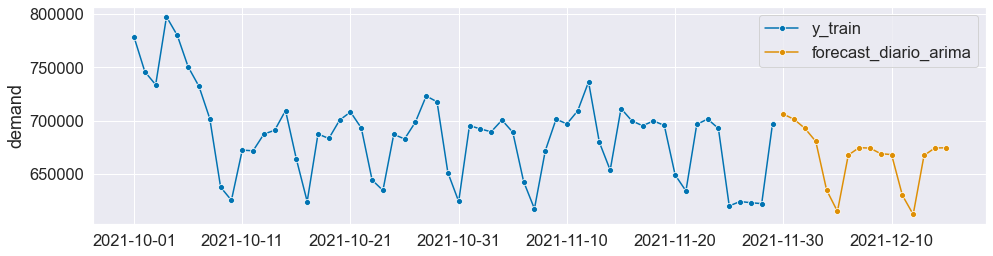

In [63]:
plot_series(y_d['2021-10-01':], forecast_d_arima,labels=["y_train", "forecast_diario_arima"])

### ARIMA A NIVEL HORARIO

In [64]:
y_train_h_log = transformer.fit_transform(y_train_h)

Veremos los residuals para ver que la serie efectivamente tiene un componente estacional que hay que tratar, este será tratado con el AutoARIMA

In [65]:
arima_hr = AutoARIMA(sp=24,suppress_warnings=True)
arima_hr.fit(y_train_h_log)

AutoARIMA(sp=24, suppress_warnings=True)

In [66]:
print(arima_hr.summary())


                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                 1408
Model:             SARIMAX(1, 1, 5)x(2, 0, [1, 2], 24)   Log Likelihood                4270.901
Date:                                 Fri, 21 Jan 2022   AIC                          -8519.803
Time:                                         16:19:19   BIC                          -8462.061
Sample:                                              0   HQIC                         -8498.223
                                                - 1408                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8470      0.032     26.787      0.000       0.785       0

Vemos que el modelo que mejor se ajusta es un modelo autoregresivo de oren 1, con diferencia de orden 1 y de media movil 1. 

In [67]:
#Vamos a predecimos el test. 
fh_h = np.arange(1, 49)
y_pred_h=np.exp(arima_hr.predict(fh_h))
y_pred_h.head()


2021-11-28 16:00    26849.989669
2021-11-28 17:00    28578.434937
2021-11-28 18:00    30215.084509
2021-11-28 19:00    29869.564635
2021-11-28 20:00    29159.847390
Freq: H, dtype: float64

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='demand'>)

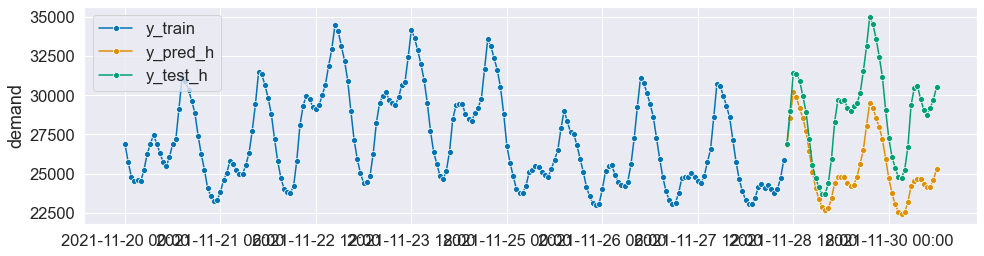

In [68]:
plot_series(y_train_h['2021-11-20':], y_pred_h,y_test_h,labels=["y_train", "y_pred_h","y_test_h"])


Al igual que en el diario, el SAIRMAXparece que toma un atendencia descendiente, lo cual no parece tçipico de la serie.

In [69]:
print('La media del error absoluto porcental es:',round(mean_absolute_percentage_error(y_test_h, y_pred_h),3))
print('El error cuadratico medio es:',round(mse(y_test_h, y_pred_h),3))
print('El error medio en terminos absolutos:',round(rmse(y_test_h, y_pred_h),3))

La media del error absoluto porcental es: 0.122
El error cuadratico medio es: 14509311.083
El error medio en terminos absolutos: 3809.109


Vemos que los errores ARIMA son más grandes que los del ETS. Esto no es buena indicación

In [70]:
y_h_log = transformer.fit_transform(y_h)

In [71]:
#Vamos a foreastear los siguientes días. 
arima_hr.fit(y_h_log)
fh_h = np.arange(1, 178)



In [72]:
print(arima_hr.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                 1456
Model:             SARIMAX(2, 1, 0)x(2, 0, [1, 2], 24)   Log Likelihood                4398.149
Date:                                 Fri, 21 Jan 2022   AIC                          -8782.298
Time:                                         16:31:57   BIC                          -8745.318
Sample:                                              0   HQIC                         -8768.501
                                                - 1456                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5626      0.021     26.922      0.000       0.522       0

In [73]:
forecast_h_arima= np.exp(arima_hr.predict(fh_h))

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='demand'>)

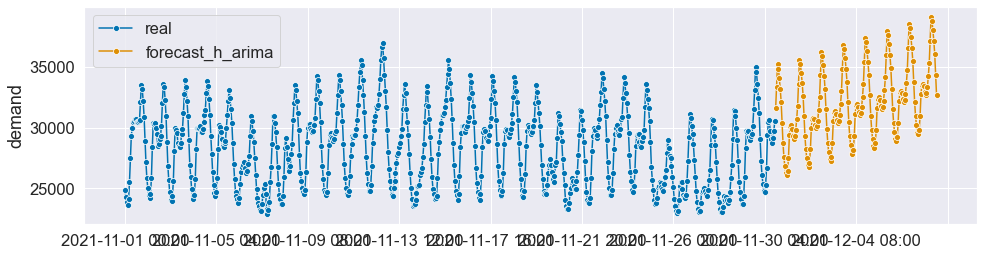

In [74]:
plot_series(y_h['2021-11-01':], forecast_h_arima,labels=["real", "forecast_h_arima"])

## Prophet

### Prophet a nivel diario

In [75]:
from prophet import Prophet

In [76]:
y_train_d_prophet=y_train_d.reset_index().rename(columns={"date_time": "ds", "demand": "y"})
y_test_d_prophet=y_test_d.reset_index().rename(columns={"date_time": "ds", "demand": "y"})

In [77]:
y_train_d_prophet['ds']=pd.to_datetime(y_train_d_prophet['ds'].astype(str))
y_test_d_prophet['ds']=pd.to_datetime(y_test_d_prophet['ds'].astype(str))

In [78]:
m_d = Prophet()
m_d.add_seasonality(name='weekly', period=7,fourier_order=5)
m_d.fit(y_train_d_prophet)

INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -6.9914


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2021.98   0.000505147       83.1345      0.8587      0.8587      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2024.44    0.00154478       150.652           1           1      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2024.93   8.92269e-06       75.0099     0.07271           1      378   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     314       2024.95   0.000165651       85.7816   2.061e-06       0.001      433  LS failed, Hessian reset 
     339       2024.96   8.84704e-08       53.0888      0.3771      0.3771      470   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [79]:
future_d = m_d.make_future_dataframe(periods=len(y_test_d_prophet))
forecast_d = m_d.predict(future_d)


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

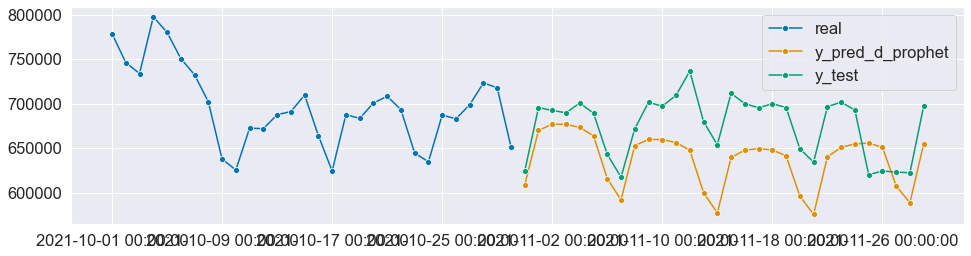

In [80]:
plot_series(y_train_d_prophet.set_index('ds')['2021-10-01':], forecast_d[['ds','yhat']].set_index('ds')['2021-10-31':], y_test_d_prophet.set_index('ds'),labels=["real", "y_pred_d_prophet",'y_test'])




In [81]:
print('La media del error absoluto porcental es:',round(mean_absolute_percentage_error(y_test_d_prophet.set_index('ds'), forecast_d[['ds','yhat']].set_index('ds')['2021-10-31':]),3))
print('El error cuadratico medio es:',round(mse(y_test_d_prophet.set_index('ds'), forecast_d[['ds','yhat']].set_index('ds')['2021-10-31':]),3))
print('El error medio en terminos absolutos:',round(rmse(y_test_d_prophet.set_index('ds'), forecast_d[['ds','yhat']].set_index('ds')['2021-10-31':]),3))



La media del error absoluto porcental es: 0.064
El error cuadratico medio es: 2160282058.21
El error medio en terminos absolutos: 46478.835


Vemos que el modelo Prophet es bastante bueno pues tiene un error medio absoluto porcentual del 6%. Aunque el ETS tine un mejor score, por lo tanto lo seguimos consideerando el ganador. 

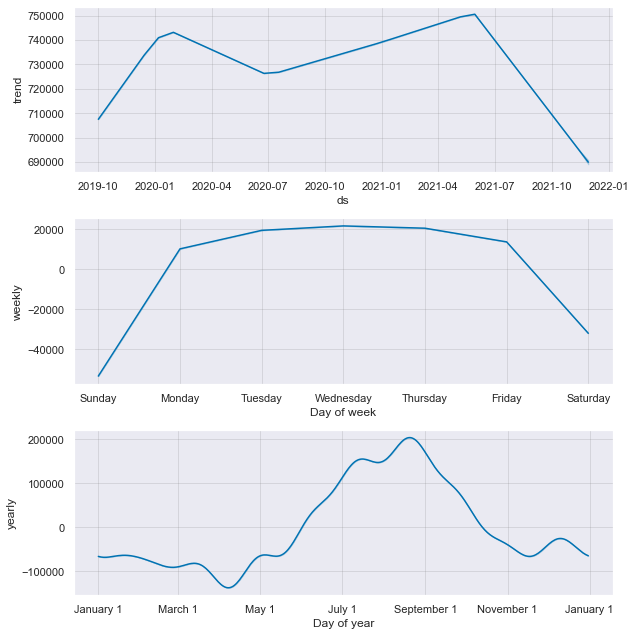

In [82]:
sns.set(font_scale = 1.0)
fig1 = m_d.plot_components(forecast_d)
plt.show()


In [83]:
future_d = m_d.make_future_dataframe(periods=(len(y_test_d_prophet)+16))
forecast_d = m_d.predict(future_d)


In [84]:
forecast_d_prophet=forecast_d[['ds','yhat']].set_index('ds')['2021-12-01':]

Hacemos el plot de todos los gráficos juntos

In [85]:

forecast_d_prophet=pd.DataFrame({'index':forecast_d_ets['2021-12-01':].index,'forecast_d_prophet':forecast_d_prophet['yhat']}).set_index('index')



In [86]:
forecast_d_all_models=pd.DataFrame({'ETS':forecast_d_ets['2021-12-01':],'ARIMA':forecast_d_arima['2021-12-01':],'PROPHET':forecast_d_prophet['forecast_d_prophet']})



(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='demand'>)

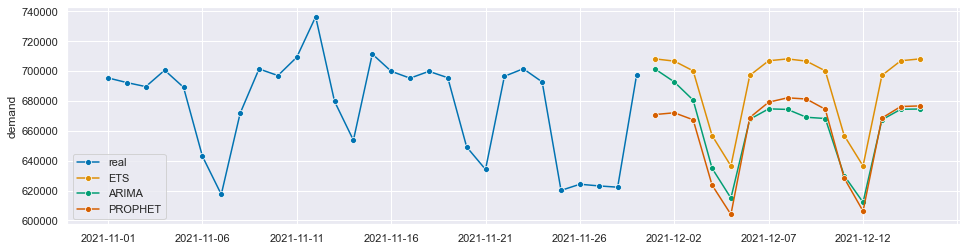

In [87]:
plot_series(y_d['2021-11-01':],forecast_d_all_models.ETS,forecast_d_all_models.ARIMA,forecast_d_all_models.PROPHET,labels=["real", "ETS",'ARIMA','PROPHET'])





In [88]:
forecast_d_all_models

,ETS,ARIMA,PROPHET
2021-12-01,708158.537776,701245.240396,670926.527811
2021-12-02,706693.418998,692760.252471,672082.085906
2021-12-03,700175.013234,680580.001012,667387.562698
2021-12-04,656858.613563,634937.581149,623669.696499
2021-12-05,636484.685505,614952.773630,603992.435415
2021-12-06,697120.153039,667745.324232,668883.541580
2021-12-07,706943.026569,674715.236105,679182.329186
2021-12-08,708158.537776,674331.478879,682108.706624
2021-12-09,706693.418998,669079.578857,681301.350388
2021-12-10,700175.013234,668241.867642,674426.787829


## prophet horario

In [89]:
y_train_h_prophet=y_train_h.reset_index().rename(columns={"date_time": "ds", "demand": "y"})
y_test_h_prophet=y_test_h.reset_index().rename(columns={"date_time": "ds", "demand": "y"})

In [90]:
y_train_h_prophet['ds']=pd.to_datetime(y_train_h_prophet['ds'].astype(str))
y_test_h_prophet['ds']=pd.to_datetime(y_test_h_prophet['ds'].astype(str))

In [91]:
m_h = Prophet()
m_h.add_seasonality(name='hourly', period=24,fourier_order=5)
m_h.fit(y_train_h_prophet)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -7.86662


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4127.61    0.00121383       110.807           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4131.42   0.000458385       141.188      0.9067      0.9067      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4132.89   5.63835e-05       84.2432           1           1      357   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     312        4132.9   3.13566e-05       67.2286   4.844e-07       0.001      422  LS failed, Hessian reset 
     340        4132.9   2.50845e-07       59.4749      0.2519           1      460   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [92]:
future_h = m_h.make_future_dataframe(freq='H',periods=len(y_test_h_prophet)+len(fh_h))
forecast_h = m_h.predict(future_h)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

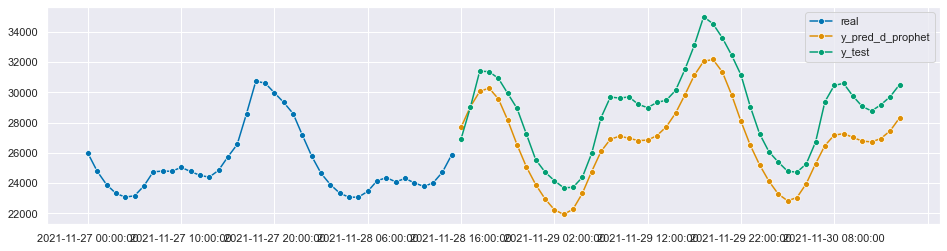

In [93]:
plot_series(y_train_h_prophet.set_index('ds')['2021-11-27':], forecast_h[['ds','yhat']].set_index('ds')['2021-11-28 16:00:00':'2021-11-30 15:00:00'], y_test_h_prophet.set_index('ds'),labels=["real", "y_pred_d_prophet",'y_test'])


In [94]:
print('La media del error absoluto porcental es:',round(mean_absolute_percentage_error(y_test_h_prophet.set_index('ds'), forecast_h[['ds','yhat']].set_index('ds')['2021-11-28 16:00:00':'2021-11-30 15:00:00']),3))
print('El error cuadratico medio es:',round(mse(y_test_h_prophet.set_index('ds'), forecast_h[['ds','yhat']].set_index('ds')['2021-11-28 16:00:00':'2021-11-30 15:00:00']),3))
print('El error medio en terminos absolutos:',round(rmse(y_test_h_prophet.set_index('ds'), forecast_h[['ds','yhat']].set_index('ds')['2021-11-28 16:00:00':'2021-11-30 15:00:00']),3))



La media del error absoluto porcental es: 0.073
El error cuadratico medio es: 4531406.275
El error medio en terminos absolutos: 2128.71


Vemos que el modelo Prophet es bastante bueno pues tiene un error medio absoluto porcentual del 6%. Aunque el ETS tine un mejor score, por lo tanto lo seguimos consideerando el ganador. 

In [104]:
len(forecast_h[['ds','yhat']].set_index('ds')['2021-11-30 15:00:00':])

178

In [111]:
forecast_h_prophet =forecast_h[['ds','yhat']].set_index('ds')['2021-11-30 16:00:00':]

In [112]:
len(forecast_h_prophet['yhat'])

177

In [113]:
forecast_h_prophet=pd.DataFrame({'index':forecast_h_ets.index,'forecast_h_prophet':forecast_h_prophet['yhat']}).set_index('index')

In [114]:
forecast_h_all_models=pd.DataFrame({'ETS':forecast_h_ets,'ARIMA':forecast_h_arima,'PROPHET':forecast_h_prophet['forecast_h_prophet']})



(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='demand'>)

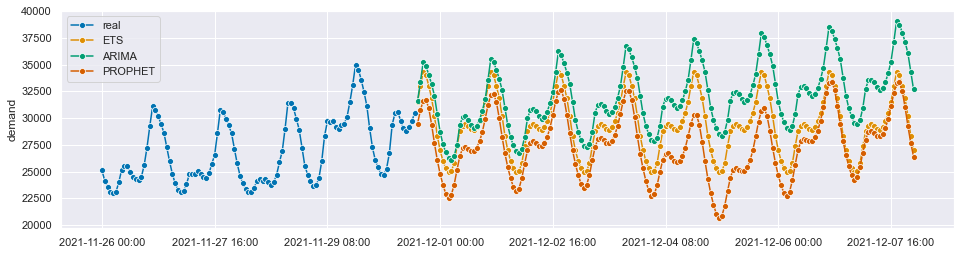

In [115]:
plot_series(y_h['2021-11-26':],forecast_h_all_models.ETS,forecast_h_all_models.ARIMA,forecast_h_all_models.PROPHET,labels=["real", "ETS",'ARIMA','PROPHET'])


In [119]:
forecast_h_all_models.to_csv('Prediccionees_Horarias')